In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings('ignore')

from gymnasium.envs.classic_control.cartpole import CartPoleEnv


class CartPoleWithFriction(CartPoleEnv):
    def __init__(self, friction_coef=0.1, render_mode=None):  # 加入 render_mode 參數
        self.friction_coef = friction_coef
        super().__init__(render_mode=render_mode)  # 傳遞給父類別
    def step(self, action):
        # 與原本相同的力（左右推）
        force = self.force_mag if action == 1 else -self.force_mag
        x, x_dot, theta, theta_dot = self.state

        # 添加地面摩擦力：對 cart 的速度做衰減
        friction_force = -self.friction_coef * x_dot
        force += friction_force

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
                   (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        # 狀態更新
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = (x, x_dot, theta, theta_dot)

        terminated = x < -self.x_threshold \
                     or x > self.x_threshold \
                     or theta < -self.theta_threshold_radians \
                     or theta > self.theta_threshold_radians
        terminated = bool(terminated)

        reward = 1.0
        self.steps_beyond_terminated = None if not terminated else self.steps_beyond_terminated

        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}




In [2]:
def make_env():
    return CartPoleWithFriction(friction_coef=0.2)  # 可調整參數

In [3]:
env = DummyVecEnv([make_env])

In [4]:
make_env().tau

0.02

Episode 10: Recent 10 episodes average reward = 449.60

Training completed! Final average reward: 449.60
Generating final test animation...
Final test: Lasted 1000 steps, Total reward: 1000.0


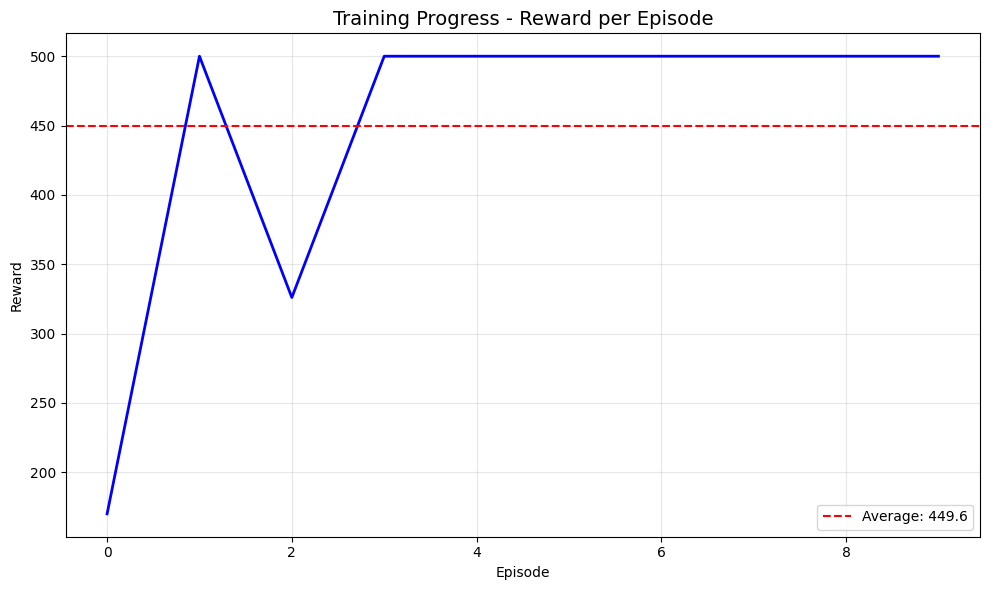

Creating animation...


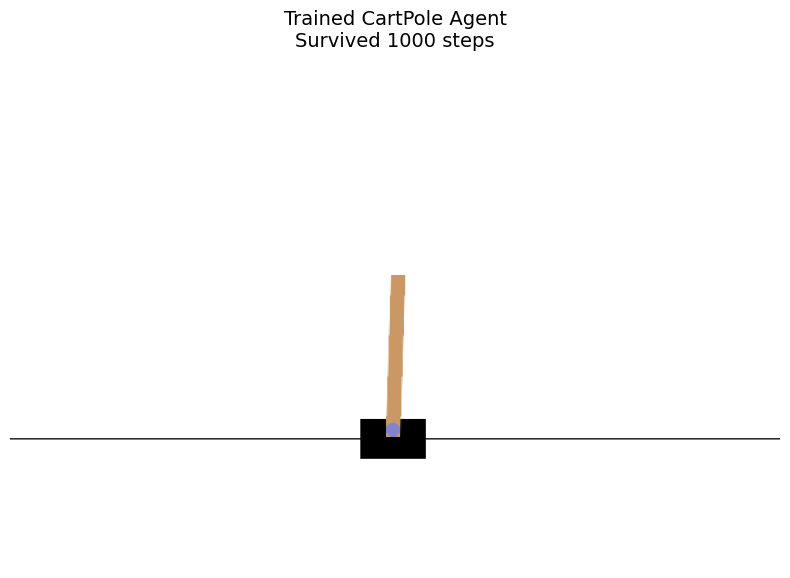

Saving animation as GIF...
Animation saved as 'cartpole_animation.gif'

=== Final Analysis ===
🎉 Congratulations! The cart has learned to balance!
   Able to maintain balance for over 500 steps - excellent performance!

CartPole final state:
- Last test duration: 1000 steps
- Last test total reward: 1000.0
- Training average reward: 449.60
- Reward improvement: +0.00 (last 10 vs first 10 episodes)

If you don't see the animation, try running in Jupyter notebook or save as GIF


In [5]:



model = PPO("MlpPolicy", env, verbose=0, device="cpu")
# Training parameters
total_episodes = 10
timesteps_per_episode = 5000
episode_rewards = []

# Training loop
for episode in range(total_episodes):
    model.learn(total_timesteps=timesteps_per_episode, reset_num_timesteps=False)
    
    # Test current model performance
    test_env = gym.make("CartPole-v1")
    obs, info = test_env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = test_env.step(action)
        total_reward += reward
        done = terminated or truncated
    
    episode_rewards.append(total_reward)
    test_env.close()
    
    # Show progress every 10 episodes
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"Episode {episode + 1}: Recent 10 episodes average reward = {avg_reward:.2f}")

print(f"\nTraining completed! Final average reward: {np.mean(episode_rewards[-10:]):.2f}")

# ======= Final test and animation part =======
print("Generating final test animation...")

# Create environment for animation
test_env = CartPoleWithFriction(friction_coef=0.2, render_mode="rgb_array")
obs, info = test_env.reset()
frames = []
done = False
step_count = 0
total_reward = 0

# Collect frames for animation
while not done and step_count < 1000:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(action)
    total_reward += reward
    done = terminated or truncated
    
    # Render and store frame
    frame = test_env.render()
    frames.append(frame)
    step_count += 1

test_env.close()

print(f"Final test: Lasted {step_count} steps, Total reward: {total_reward}")

# Create separate figures for training progress and animation
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(episode_rewards, 'b-', linewidth=2)
ax1.set_title('Training Progress - Reward per Episode', fontsize=14)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=np.mean(episode_rewards), color='r', linestyle='--', 
           label=f'Average: {np.mean(episode_rewards):.1f}')
ax1.legend()

# Show training progress
plt.tight_layout()
plt.show()

# # Create animation in separate figure
# if len(frames) > 0:
#     print("Creating animation...")
    
#     fig2, ax2 = plt.subplots(figsize=(8, 6))
#     ax2.set_title(f"Trained CartPole Agent\nSurvived {step_count} steps", fontsize=14)
#     ax2.axis('off')
    
#     # Initialize image
#     im = ax2.imshow(frames[0])
    
#     def animate_func(frame_idx):
#         if frame_idx < len(frames):
#             im.set_array(frames[frame_idx])
#         return [im]
    
#     # Create animation
#     anim = animation.FuncAnimation(
#         fig2, animate_func, frames=len(frames), 
#         interval=50, blit=True, repeat=True
#     )
    
#     # For Jupyter notebooks, uncomment the line below:
#     # from IPython.display import HTML
#     # HTML(anim.to_jshtml())
    
#     plt.tight_layout()
#     plt.show()
    
#     # Optional: Save animation as GIF (requires pillow: pip install pillow)
#     try:
#         print("Saving animation as GIF...")
#         anim.save('cartpole_animation.gif', writer='pillow', fps=20)
#         print("Animation saved as 'cartpole_animation.gif'")
#     except:
#         print("Could not save GIF (install pillow if needed)")
        
# else:
#     print("No frames collected for animation")

# # Performance analysis
# print("\n=== Final Analysis ===")
# if step_count >= 500:
#     print("🎉 Congratulations! The cart has learned to balance!")
#     print("   Able to maintain balance for over 500 steps - excellent performance!")
# elif step_count >= 200:
#     print("✅ Good! The cart has basically learned to balance")
#     print("   Although not very stable yet, there's significant improvement")
# else:
#     print("⚠️  The cart needs more training")
#     print("   Consider increasing training episodes or adjusting hyperparameters")

# print(f"\nCartPole final state:")
# print(f"- Last test duration: {step_count} steps")
# print(f"- Last test total reward: {total_reward}")
# print(f"- Training average reward: {np.mean(episode_rewards):.2f}")

# # Show reward improvement trend
# if len(episode_rewards) >= 10:
#     recent_avg = np.mean(episode_rewards[-10:])
#     early_avg = np.mean(episode_rewards[:10])
#     improvement = recent_avg - early_avg
#     print(f"- Reward improvement: +{improvement:.2f} (last 10 vs first 10 episodes)")

# print("\nIf you don't see the animation, try running in Jupyter notebook or save as GIF")

In [6]:
print("Generating final test animation and recording data...")

# Create environment for animation
test_env = CartPoleWithFriction(friction_coef=0.2, render_mode="rgb_array")
obs, info = test_env.reset()
frames = []
done = False
step_count = 0
total_reward = 0

# Data recording arrays
cart_positions = []
cart_velocities = []
pole_angles = []
pole_angular_velocities = []
actions_taken = []
rewards_received = []
timestamps = []
pole_tip_offsets = []  # 在前面定義


# Collect frames and data for analysis
while not done and step_count < 5000:
    # Record current state before action
    cart_position = obs[0]      # Cart position
    cart_velocity = obs[1]      # Cart velocity  
    pole_angle = obs[2]         # Pole angle (radians)
    pole_angular_velocity = obs[3]  # Pole angular velocity
    
    # Store state data
    cart_positions.append(cart_position)
    cart_velocities.append(cart_velocity)
    pole_angles.append(pole_angle)
    pole_angular_velocities.append(pole_angular_velocity)
    timestamps.append(step_count * 0.02)  # Assuming 50Hz (0.02s per step)
    # 在 while 迴圈內的每一步加這行：
    pole_tip_offset = test_env.unwrapped.length * np.sin(pole_angle)
    pole_tip_offsets.append(pole_tip_offset)
    
    # Get action from trained model
    action, _ = model.predict(obs, deterministic=True)
    actions_taken.append(action)
    
    # Take action and observe result
    obs, reward, terminated, truncated, info = test_env.step(action)
    rewards_received.append(reward)
    total_reward += reward
    done = terminated or truncated
    
    # Render and store frame
    frame = test_env.render()
    frames.append(frame)
    step_count += 1

test_env.close()

print(f"Final test: Lasted {step_count} steps, Total reward: {total_reward}")

# Convert lists to numpy arrays
cart_positions = np.array(cart_positions)
cart_velocities = np.array(cart_velocities)
pole_angles = np.array(pole_angles)
pole_angular_velocities = np.array(pole_angular_velocities)
actions_taken = np.array(actions_taken)
rewards_received = np.array(rewards_received)
timestamps = np.array(timestamps)
pole_tip_offsets = np.array(pole_tip_offsets)

recorded_data = {
    'cart_positions': cart_positions,
    'cart_velocities': cart_velocities,
    'pole_angles': pole_angles,
    'pole_angular_velocities': pole_angular_velocities,
    'actions_taken': actions_taken,
    'rewards_received': rewards_received,
    'timestamps': timestamps,
    'total_steps': step_count,
    'total_reward': total_reward,
    'pole_tip_offsets': pole_tip_offsets,
    'episode_rewards': np.array(episode_rewards)
}
# Save data to numpy file
data_filename = 'cartpole_training_data.npz'
np.savez(data_filename, **recorded_data)
# print(f"✅ All training and test data saved to '{data_filename}'")

# # Display data summary
# print(f"\n📊 Data Summary:")
# print(f"- Total steps recorded: {len(cart_positions)}")
# print(f"- Cart position range: [{cart_positions.min():.3f}, {cart_positions.max():.3f}]")
# print(f"- Cart velocity range: [{cart_velocities.min():.3f}, {cart_velocities.max():.3f}]")
# print(f"- Pole angle range: [{pole_angles.min():.3f}, {pole_angles.max():.3f}] radians")
# print(f"- Pole angular velocity range: [{pole_angular_velocities.min():.3f}, {pole_angular_velocities.max():.3f}] rad/s")
# print(f"- Actions taken: {np.bincount(actions_taken)} (0=left, 1=right)")

# # Create additional analysis plots
# fig3, axes = plt.subplots(2, 2, figsize=(15, 10))
# fig3.suptitle('CartPole Performance Analysis After Training', fontsize=16)

# # Plot 1: Cart position and velocity
# axes[0,0].plot(timestamps, cart_positions, 'b-', label='Position', alpha=0.7)
# ax_twin1 = axes[0,0].twinx()
# ax_twin1.plot(timestamps, cart_velocities, 'r-', label='Velocity', alpha=0.7)
# axes[0,0].set_xlabel('Time (s)')
# axes[0,0].set_ylabel('Cart Position', color='b')
# ax_twin1.set_ylabel('Cart Velocity', color='r')
# axes[0,0].set_title('Cart Position and Velocity')
# axes[0,0].grid(True, alpha=0.3)

# # Plot 2: Pole angle and angular velocity
# axes[0,1].plot(timestamps, np.degrees(pole_angles), 'g-', label='Angle (deg)', alpha=0.7)
# ax_twin2 = axes[0,1].twinx()
# ax_twin2.plot(timestamps, pole_angular_velocities, 'm-', label='Angular Velocity', alpha=0.7)
# axes[0,1].set_xlabel('Time (s)')
# axes[0,1].set_ylabel('Pole Angle (degrees)', color='g')
# ax_twin2.set_ylabel('Angular Velocity (rad/s)', color='m')
# axes[0,1].set_title('Pole Angle and Angular Velocity')
# axes[0,1].grid(True, alpha=0.3)

# # Plot 3: Actions over time
# axes[1,0].plot(timestamps, actions_taken, 'ko-', markersize=2, alpha=0.6)
# axes[1,0].set_xlabel('Time (s)')
# axes[1,0].set_ylabel('Action (0=Left, 1=Right)')
# axes[1,0].set_title('Actions Taken Over Time')
# axes[1,0].grid(True, alpha=0.3)
# axes[1,0].set_ylim(-0.1, 1.1)

# # Plot 4: Phase space (position vs velocity)
# scatter = axes[1,1].scatter(cart_positions, cart_velocities, c=timestamps, 
#                           cmap='viridis', alpha=0.6, s=10)
# axes[1,1].set_xlabel('Cart Position')
# axes[1,1].set_ylabel('Cart Velocity')
# axes[1,1].set_title('Cart Phase Space (Position vs Velocity)')
# axes[1,1].grid(True, alpha=0.3)
# plt.colorbar(scatter, ax=axes[1,1], label='Time (s)')

# plt.tight_layout()
# plt.show()

# print(f"📈 Analysis plots generated showing system behavior over time")

# # ======= Fourier Transform Analysis =======
# print(f"\n🔬 Performing Fourier Transform Analysis on Velocities...")

# Calculate sampling parameters
dt = 0.02  # Time step (50Hz sampling rate)
fs = 1/dt  # Sampling frequency (50 Hz)
N = len(cart_velocities)  # Number of samples

# Perform FFT on cart velocity
cart_vel_fft = np.fft.fft(cart_velocities)
cart_vel_freqs = np.fft.fftfreq(N, dt)
cart_vel_magnitude = np.abs(cart_vel_fft)
cart_vel_phase = np.angle(cart_vel_fft)

# Perform FFT on pole angular velocity
pole_angvel_fft = np.fft.fft(pole_angular_velocities)
pole_angvel_freqs = np.fft.fftfreq(N, dt)
pole_angvel_magnitude = np.abs(pole_angvel_fft)
pole_angvel_phase = np.angle(pole_angvel_fft)

# Only keep positive frequencies for plotting
positive_freq_idx = cart_vel_freqs > 0
cart_pos_freqs = cart_vel_freqs[positive_freq_idx]
cart_pos_magnitude = cart_vel_magnitude[positive_freq_idx]
cart_pos_phase = cart_vel_phase[positive_freq_idx]

pole_pos_freqs = pole_angvel_freqs[positive_freq_idx]
pole_pos_magnitude = pole_angvel_magnitude[positive_freq_idx]
pole_pos_phase = pole_angvel_phase[positive_freq_idx]


# Find dominant frequencies
def find_dominant_frequencies(freqs, magnitudes, threshold_ratio=0.1):
    """Find frequencies with significant magnitude"""
    max_magnitude = np.max(magnitudes)
    threshold = max_magnitude * threshold_ratio
    dominant_indices = magnitudes > threshold
    return freqs[dominant_indices], magnitudes[dominant_indices]

# Analyze dominant frequencies (excluding DC component at 0 Hz)
cart_dom_freqs, cart_dom_mags = find_dominant_frequencies(
    cart_pos_freqs[cart_pos_freqs > 0.1], 
    cart_pos_magnitude[cart_pos_freqs > 0.1]
)

pole_dom_freqs, pole_dom_mags = find_dominant_frequencies(
    pole_pos_freqs[pole_pos_freqs > 0.1], 
    pole_pos_magnitude[pole_pos_freqs > 0.1]
)

# Calculate power spectral density
cart_psd = cart_vel_magnitude**2 / N
pole_psd = pole_angvel_magnitude**2 / N

# Save FFT data to numpy file
fft_data = {
    'cart_velocity_fft_magnitude': cart_vel_magnitude,
    'cart_velocity_fft_phase': cart_vel_phase,
    'cart_velocity_frequencies': cart_vel_freqs,
    'pole_angvel_fft_magnitude': pole_angvel_magnitude,
    'pole_angvel_fft_phase': pole_angvel_phase,
    'pole_angvel_frequencies': pole_angvel_freqs,
    'sampling_frequency': fs,
    'time_step': dt,
    'cart_power_spectral_density': cart_psd,
    'pole_power_spectral_density': pole_psd
}

fft_filename = 'cartpole_fft_analysis.npz'
np.savez(fft_filename, **fft_data)


# Calculate RMS values
cart_vel_rms = np.sqrt(np.mean(cart_velocities**2))
pole_angvel_rms = np.sqrt(np.mean(pole_angular_velocities**2))



Generating final test animation and recording data...
Final test: Lasted 5000 steps, Total reward: 5000.0


In [7]:
pole_half_length = test_env.unwrapped.length
pole_full_length = pole_half_length * 2

print(f"Pole half length: {pole_half_length}")
print(f"Pole full length: {pole_full_length}")

Pole half length: 0.5
Pole full length: 1.0


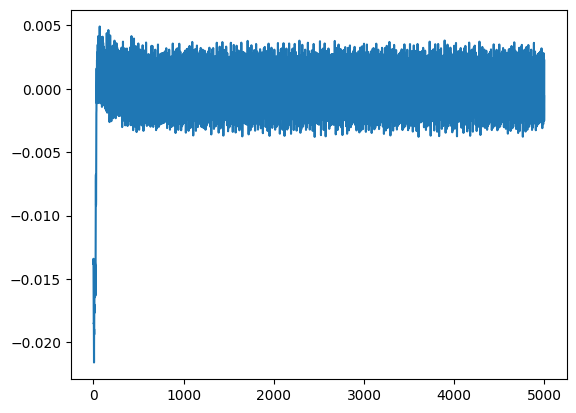

In [8]:
plt.plot(pole_tip_offsets 
)

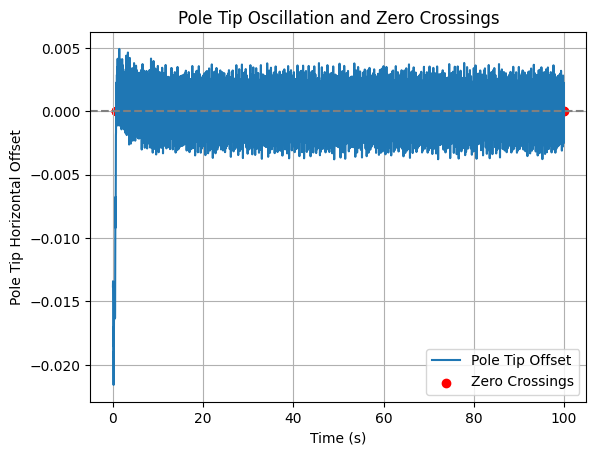

In [9]:
zero_crossing_indices = np.where(np.diff(np.sign(pole_tip_offsets)) != 0)[0]

# 加上 1，因為 np.diff 產生的是 N-1 長度
zero_crossing_times = timestamps[zero_crossing_indices + 1]
plt.plot(timestamps, pole_tip_offsets, label='Pole Tip Offset')
plt.scatter(zero_crossing_times, np.zeros_like(zero_crossing_times), color='red', label='Zero Crossings')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Pole Tip Horizontal Offset")
plt.legend()
plt.title("Pole Tip Oscillation and Zero Crossings")
plt.grid(True)
plt.show()

In [10]:
zero_crossing_times

array([ 0.7 ,  0.74,  0.78, ..., 99.88, 99.9 , 99.98], shape=(1765,))

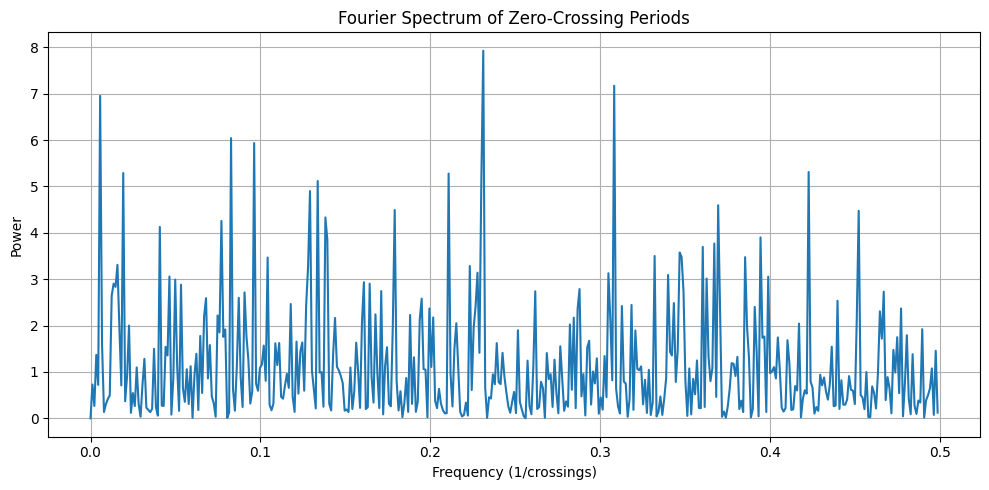

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# 假設你已有 zero_crossing_times，如：
# zero_crossing_times = np.array([...])

# Step 1: 取偶數 index 的過零時間點
even_crossing_times = zero_crossing_times[::2]

# Step 2: 計算每個週期的時間長度
periods = np.diff(even_crossing_times)  # 相鄰時間差，應該接近週期
N = len(periods)
dt = 1  # 每個樣本對應一個週期，不需要真實時間尺度

# Step 3: FFT 分析
yf = fft(periods - np.mean(periods))  # 去除 DC 分量 (均值)
xf = fftfreq(N, dt)

# 只取正頻率部分
xf_pos = xf[:N//2]
power_spectrum = np.abs(yf[:N//2])**2

# Step 4: 繪圖
plt.figure(figsize=(10, 5))
plt.plot(xf_pos, power_spectrum)
plt.xlabel("Frequency (1/crossings)")
plt.ylabel("Power")
plt.title("Fourier Spectrum of Zero-Crossing Periods")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
len(xf)

882

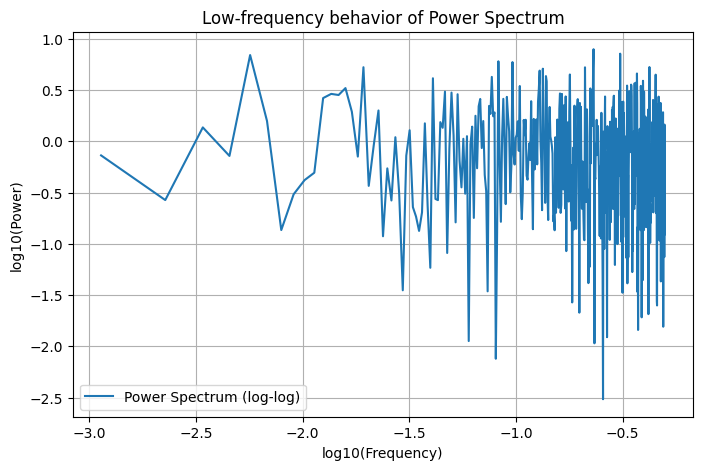

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


N = len(periods)
dt = 1  # index 間隔

yf = fft(periods)
xf = fftfreq(N, dt)
xf = xf[:N//2]
power = np.abs(yf[:N//2])**2

# 避免 log(0)，加個 epsilon
epsilon = 1e-12
log_xf = np.log10(xf[1:] + epsilon)
log_power = np.log10(power[1:] + epsilon)

plt.figure(figsize=(8, 5))
plt.plot(log_xf, log_power, label='Power Spectrum (log-log)')
plt.xlabel('log10(Frequency)')
plt.ylabel('log10(Power)')
plt.title('Low-frequency behavior of Power Spectrum')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
len(xf)

441

In [15]:
log_power 

array([-1.37025100e-01, -5.72784032e-01,  1.36141333e-01, -1.42140422e-01,
        8.42151502e-01,  1.99081122e-01, -8.65396699e-01, -5.16307481e-01,
       -3.78224842e-01, -3.05909679e-01,  4.22336385e-01,  4.63201028e-01,
        4.52350894e-01,  5.19784716e-01,  2.89272748e-01, -1.48450229e-01,
        7.23403759e-01, -4.34293630e-01, -3.85467976e-02,  3.01396224e-01,
       -9.26077205e-01, -2.63706697e-01, -5.76758283e-01,  4.03576292e-02,
       -5.05079362e-01, -1.45320099e+00, -1.39618304e-01,  1.08450846e-01,
       -6.41715221e-01, -7.34015043e-01, -8.74030637e-01, -6.93323814e-01,
        1.75772834e-01, -6.29025187e-01, -1.23363334e+00,  6.15643586e-01,
       -5.61921288e-01, -5.73261889e-01,  1.87821054e-01,  1.32200851e-01,
        4.85494195e-01, -1.08909620e+00, -7.02030486e-02,  4.75856076e-01,
        5.67021715e-02, -7.90342236e-01,  4.59687485e-01, -1.88198595e-01,
       -4.48873051e-01,  2.51339978e-02, -5.10587617e-01,  5.05325517e-02,
       -1.94851420e+00, -